In [1]:
import pandas as pd
import janitor
from IPython.display import display
from utilities import pandas_to_tex, save_mpl_fig
import warnings
import sidetable

pd.set_option("display.max_colwidth", None)
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(context="notebook", font_scale=1.2, style="whitegrid", palette="dark")

/home/lsys/bad_domains/scripts/utilities.py:853: DeprecationWarning: invalid escape sequence '\%'
  lambda row: f"{int(row['count'])} ({row['percent']}\%)", axis=1


In [2]:
df = (
    # ==================================================
    pd.read_csv("../data/yg_ind_domain.csv.gz")
    .assign(
        duration_min=lambda df_: df_["duration"] / 60,
        duration_hr=lambda df_: df_["duration"] / 3600,
    )
    # ==================================================
    # Merge to VT
    .merge(
        (pd.read_csv("../data/yg_virustotal_dat.csv")),
        how="left",
        left_on="private_domain",
        right_on="filename",
        validate="m:1",
    )
    .assign(
        malicious_bool=lambda df_: np.where(df_["malicious"] >= 2, True, False),
        suspicious_bool=lambda df_: df_["suspicious"].astype("bool"),
        tt_malicious_visits=lambda df_: df_["malicious_bool"] * df_["visits"],
        tt_malicious_min=lambda df_: df_["malicious_bool"] * df_["duration_min"],
        vendors=lambda df_: df_["harmless"]
        + df_["malicious"]
        + df_["suspicious"]
        + df_["undetected"],
    )
    # ==================================================
    # Aggregate to domain
    .remove_columns("caseid")
    .groupby(["private_domain", "malicious_bool", "suspicious_bool", "vendors"])[["tt_malicious_visits", "tt_malicious_min"]]
    .sum()
    .astype(int)
    .reset_index()
    # ==================================================
    # Merge back to get domain char.
    .merge(
        (pd.read_csv("../data/yg_virustotal_dat.csv")),
        how="left",
        left_on="private_domain",
        right_on="filename",
        validate="1:1",
    )
    # ==================================================
    # Merge to get YouGov cat
    .merge(
        (
            pd.read_csv("../data/6.3m-ind-domain-data.csv.gz")
            .select_columns(["private_domain", "category"])
            .drop_duplicates(["private_domain", "category"])
            .dropna(subset=["category"])
            # Concatenate cat for those with multiple cats
            # (e.g., Google with Search Engines and Portals and Business and Email)
            .groupby("private_domain", as_index=False)
            .agg({"category": lambda x: " | ".join(sorted(set(filter(None, x))))})
            .rename_column("category", "yougov")
        ),
        how="left",
        on="private_domain",
        validate="1:1",
    )
    .remove_columns("filename")
    .sort_values("tt_malicious_visits", ascending=False, ignore_index=True)
)
display(df.head(10))
df.info()

,private_domain,malicious_bool,suspicious_bool,vendors,tt_malicious_visits,tt_malicious_min,harmless,malicious,suspicious,undetected,timeout,forcepoint,sophos,bitdefender,comodo,alphamnt,yougov
0,omnatuor.com,True,True,87.0,1408,378,61,6,2,18,0,information technology. potentially unwanted software,content delivery,NaN,NaN,Suspicious,NaN
1,e621.net,True,False,87.0,1277,374,66,2,0,19,0,adult content,blogs and forums,entertainment,NaN,"Personal Sites/Blogs, Pornography",Messageboards and Forums
2,watchserieshd.tv,True,False,87.0,718,324,64,2,0,21,0,hacking,intellectual piracy,videos,NaN,"Piracy/Plagiarism, Video/Multimedia",Entertainment
3,glersakr.com,True,True,87.0,705,489,64,2,2,19,0,information technology. potentially unwanted software,content delivery,NaN,NaN,Suspicious,NaN
4,r.appspot.com,True,True,87.0,527,142,65,2,1,19,0,web hosting,information technology,NaN,NaN,NaN,"Business, Education, Information Technology | Uncategorized"
5,rockslootni.com,True,False,87.0,500,186,56,11,0,20,0,malicious web sites,spyware and malware,NaN,NaN,Malicious,NaN
6,picpushes.com,True,False,87.0,470,254,63,3,0,21,0,web infrastructure,photo galleries,parked,NaN,Phishing,NaN
7,opinionsquare.com,True,False,87.0,442,128,65,2,0,20,0,pay-to-surf,NaN,misc,NaN,Ads/Analytics,Business | Shopping
8,playkooblni.com,True,False,87.0,419,159,61,6,0,20,0,NaN,NaN,NaN,NaN,Malicious,NaN
9,topdisplayformat.com,True,False,87.0,390,35,65,2,0,20,0,malicious web sites,search engines,NaN,NaN,Search Engines/Portals,Business


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64020 entries, 0 to 64019
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   private_domain       64020 non-null  object 
 1   malicious_bool       64020 non-null  bool   
 2   suspicious_bool      64020 non-null  bool   
 3   vendors              64020 non-null  float64
 4   tt_malicious_visits  64020 non-null  int64  
 5   tt_malicious_min     64020 non-null  int64  
 6   harmless             64020 non-null  int64  
 7   malicious            64020 non-null  int64  
 8   suspicious           64020 non-null  int64  
 9   undetected           64020 non-null  int64  
 10  timeout              64020 non-null  int64  
 11  forcepoint           47931 non-null  object 
 12  sophos               27111 non-null  object 
 13  bitdefender          43373 non-null  object 
 14  comodo               13121 non-null  object 
 15  alphamnt             36054 non-null 

## Tabulate

### Most common categories

In [3]:
_n = 15
fp_cat = (
    df.query("malicious>=2")
    .stb.freq(["forcepoint"])
    .head(_n)
    .assign(ix=range(1, 1 + _n))
    .reorder_columns(["ix"])
    .fillna("---")
)
fp_cat

,ix,forcepoint,count,percent,cumulative_count,cumulative_percent
0,1,information technology,151,20.160214,151,20.160214
1,2,search engines and portals,63,8.411215,214,28.571429
2,3,sex,45,6.008011,259,34.579439
3,4,business and economy,33,4.405874,292,38.985314
4,5,hacking,26,3.471295,318,42.456609
5,6,malicious web sites,24,3.204272,342,45.660881
6,7,suspicious content,22,2.937250,364,48.598131
7,8,financial data and services,22,2.937250,386,51.535381
8,9,web infrastructure,21,2.803738,407,54.339119
9,10,games,21,2.803738,428,57.142857


In [4]:
am_cat = (
    df.query("malicious>=2")
    .replace("Phishing (alphaMountain.ai)", "Phishing")
    .replace("Malicious (alphaMountain.ai)", "Malicious")
    .stb.freq(["alphamnt"])
    .head(_n)
)
am_cat

,alphamnt,count,percent,cumulative_count,cumulative_percent
0,Phishing,164,20.347395,164,20.347395
1,Malicious,133,16.501241,297,36.848635
2,Suspicious,83,10.297767,380,47.146402
3,Information Technology,16,1.985112,396,49.131514
4,"Malicious, Phishing",15,1.861042,411,50.992556
5,Unrated,14,1.736973,425,52.729529
6,Search Engines/Portals,14,1.736973,439,54.466501
7,Entertainment,14,1.736973,453,56.203474
8,"Malicious, Parked Site",12,1.488834,465,57.692308
9,"Malicious, Search Engines/Portals",10,1.240695,475,58.933002


In [5]:
sophos_cat = df.query("malicious>=2").stb.freq(["sophos"]).head(_n)
sophos_cat

,sophos,count,percent,cumulative_count,cumulative_percent
0,information technology,76,16.593886,76,16.593886
1,phishing and fraud,73,15.938865,149,32.532751
2,spyware and malware,48,10.480349,197,43.013100
3,content delivery,42,9.170306,239,52.183406
4,search engines,36,7.860262,275,60.043668
5,general business,27,5.895197,302,65.938865
6,sexually explicit,25,5.458515,327,71.397380
7,video hosting,19,4.148472,346,75.545852
8,parked domains,17,3.711790,363,79.257642
9,entertainment,17,3.711790,380,82.969432


In [6]:
bitdefender_cat = (
    df.query("malicious>=2")
    .replace("computersandsoftware", "computers and software")
    .stb.freq(["bitdefender"])
    .head(_n)
)
bitdefender_cat

,bitdefender,count,percent,cumulative_count,cumulative_percent
0,parked,152,25.041186,152,25.041186
1,misc,122,20.098847,274,45.140033
2,business,58,9.555189,332,54.695222
3,porn,48,7.907743,380,62.602965
4,computers and software,31,5.107084,411,67.710049
5,games,23,3.789127,434,71.499176
6,blogs,23,3.789127,457,75.288303
7,entertainment,21,3.459638,478,78.747941
8,financial,12,1.976936,490,80.724876
9,videos,10,1.647446,500,82.372323


In [7]:
yg_cat = df.query("malicious>=2").stb.freq(["yougov"]).head(_n)
yg_cat

,yougov,count,percent,cumulative_count,cumulative_percent
0,Business,78,23.283582,78,23.283582
1,Parked,35,10.447761,113,33.731343
2,"Business, Information Technology",28,8.358209,141,42.089552
3,Adult,27,8.059701,168,50.149254
4,Entertainment,23,6.865672,191,57.014925
5,"Business, Education",14,4.179104,205,61.194030
6,Information Technology,12,3.582090,217,64.776119
7,"Entertainment, Illegal Content",9,2.686567,226,67.462687
8,"Information Technology, Media Sharing",7,2.089552,233,69.552239
9,Education,7,2.089552,240,71.641791


In [8]:
# make tab
df_categories = (
    pd.concat([fp_cat, am_cat, sophos_cat, bitdefender_cat, yg_cat], axis=1)
    #     pd.concat(
    #         [
    #             fp_cat,
    #             am_cat,
    #             sophos_cat,
    #             bitdefender_cat,
    #         ],
    #         axis=1,
    #     )
    .apply(
        lambda col: col.map(
            #             lambda x: f"{x:.0f}\%" if pd.api.types.is_numeric_dtype(col) and pd.notnull(x) else x
            lambda x: f"{x:.0f}"
            if pd.api.types.is_numeric_dtype(col) and pd.notnull(x)
            else x
        )
        if "percent" in col.name or "cumulative_percent" in col.name
        else col
    )
#     .replace("and", "\&", regex=True)
    .remove_columns("count")
    .remove_columns("cumulative_count")
    .remove_columns("cumulative_percent")
    .head(_n)
    .fillna("---")
    .applymap(lambda x: x.title() if isinstance(x, str) else x)
    # =========================================================
    # To be consistent with 09_inspecting_VT
    # forcepoint
    .replace(". Potentially Unwanted Software", ", PUA", regex=True)
    .replace("Potentially Unwanted Software.", "PUA, ", regex=True)
    .replace("Information Technology", "IT", regex=True)
    .replace("Search Engines And Portals", "Search Engines", regex=True)
    .replace("Search Engines/Portals", "Search Engines", regex=True)
    .replace("Malicious Web Sites", "Malicious", regex=True)
    .replace("Adult Content", "Adult", regex=True)
    .replace("Advertisements", "Ads", regex=True)
    .replace("Phishing And Other Frauds", "Phishing", regex=True)
    .replace("News And Media", "News", regex=True)
           .replace("Web Infrastructure", "CDN", regex=True)
 # sophos
    .replace("Content Delivery", "CDN", regex=True)
    .replace("Spyware And Malware", "Malware", regex=True)
    .replace("Photo Galleries", "Photos", regex=True)
    .replace("Sexually Explicit", "Explicit", regex=True)
    .replace("Video Hosting", "Streaming", regex=True)
    # bitdefender
    .replace("Onlinedating", "Online Dating", regex=True)
    # comodo
    .replace("Media Sharing", "Media", regex=True)
    # alphamnt
    .replace("Potentially Unwanted Programs", "PUA", regex=True)
    .replace("Entertainment, Media, Scam/Illegal/Unethical, Video/Multimedia", "Entertainment, Scam/Illegal, Streaming", regex=True)
    .replace("Entertainment, Scam/Illegal/Unethical, Video/Multimedia", "Entertainment, Scam/Illegal, Streaming", regex=True)
    # =======================================================
    # Additional shorteners
    # forcepoint
    .replace("Suspicious Content", "Suspicious", regex=True)
    .replace("Financial Data And Services", "Financial", regex=True)
    # alphamnt
    .replace("Parked Site", "Parked", regex=True)
    .replace("Content Servers", "CDN", regex=True)
    # sophos
    .replace("Phishing And Fraud", "Phishing/Fraud", regex=True)
    .replace("Parked Domains", "Parked", regex=True)
    .replace("Personal Network Storage", "NAS/Storage", regex=True)
    .replace("Dynamic Dns And Isp Sites", "DNS/ISP", regex=True)
    # yougov
    .replace("Illegal Content", "Illegal", regex=True)
    .replace("Proxy And Filter Avoidance", "Proxy/VPN", regex=True)
    .replace("and", "\&", regex=True)
    .replace("And", "\&", regex=True)
)
display(df_categories)
pandas_to_tex(df_categories, "../tabs/top15_malicious_categories")

,ix,forcepoint,percent,alphamnt,percent,sophos,percent,bitdefender,percent,yougov,percent
0,1,IT,20,Phishing,20,IT,17,Parked,25,Business,23
1,2,Search Engines,8,Malicious,17,Phishing/Fraud,16,Misc,20,Parked,10
2,3,Sex,6,Suspicious,10,Malware,10,Business,10,"Business, IT",8
3,4,Business \& Economy,4,IT,2,CDN,9,Porn,8,Adult,8
4,5,Hacking,3,"Malicious, Phishing",2,Search Engines,8,Computers \& Software,5,Entertainment,7
5,6,Malicious,3,Unrated,2,General Business,6,Games,4,"Business, Education",4
6,7,Suspicious,3,Search Engines,2,Explicit,5,Blogs,4,IT,4
7,8,Financial,3,Entertainment,2,Streaming,4,Entertainment,3,"Entertainment, Illegal",3
8,9,CDN,3,"Malicious, Parked",1,Parked,4,Financial,2,"IT, Media",2
9,10,Games,3,"Malicious, Search Engines",1,Entertainment,4,Videos,2,Education,2


In [9]:
!cat ../tabs/top15_malicious_categories.tex

1 & IT & 20 & Phishing & 20 & IT & 17 & Parked & 25 & Business & 23 \\
2 & Search Engines & 8 & Malicious & 17 & Phishing/Fraud & 16 & Misc & 20 & Parked & 10 \\
3 & Sex & 6 & Suspicious & 10 & Malware & 10 & Business & 10 & Business, IT & 8 \\
4 & Business \& Economy & 4 & IT & 2 & CDN & 9 & Porn & 8 & Adult & 8 \\
5 & Hacking & 3 & Malicious, Phishing & 2 & Search Engines & 8 & Computers \& Software & 5 & Entertainment & 7 \\
6 & Malicious & 3 & Unrated & 2 & General Business & 6 & Games & 4 & Business, Education & 4 \\
7 & Suspicious & 3 & Search Engines & 2 & Explicit & 5 & Blogs & 4 & IT & 4 \\
8 & Financial & 3 & Entertainment & 2 & Streaming & 4 & Entertainment & 3 & Entertainment, Illegal & 3 \\
9 & CDN & 3 & Malicious, Parked & 1 & Parked & 4 & Financial & 2 & IT, Media & 2 \\
10 & Games & 3 & Malicious, Search Engines & 1 & Entertainment & 4 & Videos & 2 & Education & 2 \\
11 & Compromised Websites & 3 & IT, Suspicious & 1 & NAS/Storage & 2 & Hosting & 2 & Business, Economy \

## Descriptions

In [11]:
len(df.query("malicious_bool==1")), 100 * (len(df.query("malicious_bool==1")) / len(df))

(1128, 1.76194939081537)

In [12]:
len(df.query("malicious>1")), 100 * (len(df.query("malicious>1")) / len(df))

(1128, 1.76194939081537)

In [13]:
100 * (len(df.query("malicious>1")) / len(df.query("malicious_bool==1")))

100.0

In [14]:
len(df.query("suspicious_bool==1")), 100 * (
    len(df.query("suspicious_bool==1")) / len(df)
)

(1336, 2.0868478600437363)

In [15]:
df["vendors"].describe()

count    64020.000000
mean        87.468635
std          0.534623
min         86.000000
25%         87.000000
50%         87.000000
75%         88.000000
max         89.000000
Name: vendors, dtype: float64

In [16]:
df["malicious"].describe()

count    64020.000000
mean         0.118588
std          0.680887
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         17.000000
Name: malicious, dtype: float64

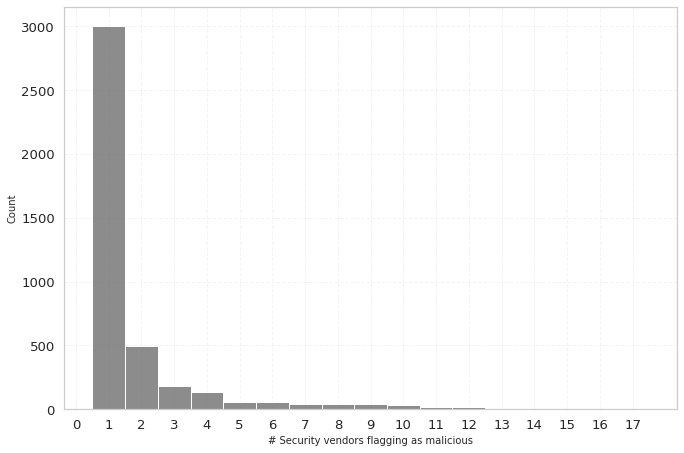

In [17]:
_scale = 0.8
_aspect_ratio = (12, 8)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

sns.histplot(df.query("malicious>0")["malicious"], color=".4", discrete=True)
plt.xticks(ticks=range(int(df["malicious"].min()), int(df["malicious"].max()) + 1))
plt.xlabel("# Security vendors flagging as malicious")
plt.ylabel
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
save_mpl_fig("../figs/vendor-agreement-malicious")

## Top sites

In [18]:
# Most frequented malicious sites
(df.sort_values("tt_malicious_visits", ascending=False, ignore_index=True).head(15))

,private_domain,malicious_bool,suspicious_bool,vendors,tt_malicious_visits,tt_malicious_min,harmless,malicious,suspicious,undetected,timeout,forcepoint,sophos,bitdefender,comodo,alphamnt,yougov
0,omnatuor.com,True,True,87.0,1408,378,61,6,2,18,0,information technology. potentially unwanted software,content delivery,NaN,NaN,Suspicious,NaN
1,e621.net,True,False,87.0,1277,374,66,2,0,19,0,adult content,blogs and forums,entertainment,NaN,"Personal Sites/Blogs, Pornography",Messageboards and Forums
2,watchserieshd.tv,True,False,87.0,718,324,64,2,0,21,0,hacking,intellectual piracy,videos,NaN,"Piracy/Plagiarism, Video/Multimedia",Entertainment
3,glersakr.com,True,True,87.0,705,489,64,2,2,19,0,information technology. potentially unwanted software,content delivery,NaN,NaN,Suspicious,NaN
4,r.appspot.com,True,True,87.0,527,142,65,2,1,19,0,web hosting,information technology,NaN,NaN,NaN,"Business, Education, Information Technology | Uncategorized"
5,rockslootni.com,True,False,87.0,500,186,56,11,0,20,0,malicious web sites,spyware and malware,NaN,NaN,Malicious,NaN
6,picpushes.com,True,False,87.0,470,254,63,3,0,21,0,web infrastructure,photo galleries,parked,NaN,Phishing,NaN
7,opinionsquare.com,True,False,87.0,442,128,65,2,0,20,0,pay-to-surf,NaN,misc,NaN,Ads/Analytics,Business | Shopping
8,playkooblni.com,True,False,87.0,419,159,61,6,0,20,0,NaN,NaN,NaN,NaN,Malicious,NaN
9,topdisplayformat.com,True,False,87.0,390,35,65,2,0,20,0,malicious web sites,search engines,NaN,NaN,Search Engines/Portals,Business


In [19]:
# Most frequented malicious sites
(df.sort_values("malicious", ascending=False, ignore_index=True).head(15))

,private_domain,malicious_bool,suspicious_bool,vendors,tt_malicious_visits,tt_malicious_min,harmless,malicious,suspicious,undetected,timeout,forcepoint,sophos,bitdefender,comodo,alphamnt,yougov
0,helpinprogress.com,True,False,88.0,1,0,51,17,0,20,0,blogs and personal sites,phishing and fraud,parked,NaN,"Phishing, Scam/Illegal/Unethical",NaN
1,prizeshub.com,True,False,87.0,3,0,52,16,0,19,0,content delivery networks,phishing and fraud,parked,NaN,Phishing,Parked
2,intelligence101.com,True,False,87.0,9,11,52,15,0,20,0,business and economy,phishing and fraud,parked,NaN,Phishing,NaN
3,ggtraff.ru,True,False,87.0,2,0,55,14,0,18,0,phishing and other frauds,phishing and fraud,parked,NaN,"Malicious, Phishing",NaN
4,phone-location.info,True,False,88.0,1,0,55,14,0,19,0,phishing and other frauds,phishing and fraud,business,NaN,Phishing,NaN
5,aniaroth.com,True,False,87.0,2,0,54,14,0,19,0,malicious web sites. blogs and personal sites,phishing and fraud,business,NaN,Phishing,NaN
6,facehokups.com,True,False,88.0,8,7,53,13,0,22,0,sex,phishing and fraud,NaN,NaN,"Malicious, Phishing",NaN
7,crackit.org,True,False,88.0,2,0,55,13,0,20,0,hacking,spyware and malware,filesharing,NaN,"Hacking, Malicious",NaN
8,torodate.com,True,False,87.0,2,0,54,13,0,20,0,NaN,phishing and fraud,NaN,NaN,Phishing,NaN
9,ne-zalivaet.ru,True,False,88.0,2,0,54,13,0,21,0,information technology,phishing and fraud,parked,NaN,Phishing (alphaMountain.ai),NaN


In [20]:
# Most frequented malicious sites (at least 2 flagged)
(
    df.query("malicious>1")
    .sort_values("tt_malicious_visits", ascending=False, ignore_index=True)
    .head(15)
)

,private_domain,malicious_bool,suspicious_bool,vendors,tt_malicious_visits,tt_malicious_min,harmless,malicious,suspicious,undetected,timeout,forcepoint,sophos,bitdefender,comodo,alphamnt,yougov
0,omnatuor.com,True,True,87.0,1408,378,61,6,2,18,0,information technology. potentially unwanted software,content delivery,NaN,NaN,Suspicious,NaN
1,e621.net,True,False,87.0,1277,374,66,2,0,19,0,adult content,blogs and forums,entertainment,NaN,"Personal Sites/Blogs, Pornography",Messageboards and Forums
2,watchserieshd.tv,True,False,87.0,718,324,64,2,0,21,0,hacking,intellectual piracy,videos,NaN,"Piracy/Plagiarism, Video/Multimedia",Entertainment
3,glersakr.com,True,True,87.0,705,489,64,2,2,19,0,information technology. potentially unwanted software,content delivery,NaN,NaN,Suspicious,NaN
4,r.appspot.com,True,True,87.0,527,142,65,2,1,19,0,web hosting,information technology,NaN,NaN,NaN,"Business, Education, Information Technology | Uncategorized"
5,rockslootni.com,True,False,87.0,500,186,56,11,0,20,0,malicious web sites,spyware and malware,NaN,NaN,Malicious,NaN
6,picpushes.com,True,False,87.0,470,254,63,3,0,21,0,web infrastructure,photo galleries,parked,NaN,Phishing,NaN
7,opinionsquare.com,True,False,87.0,442,128,65,2,0,20,0,pay-to-surf,NaN,misc,NaN,Ads/Analytics,Business | Shopping
8,playkooblni.com,True,False,87.0,419,159,61,6,0,20,0,NaN,NaN,NaN,NaN,Malicious,NaN
9,topdisplayformat.com,True,False,87.0,390,35,65,2,0,20,0,malicious web sites,search engines,NaN,NaN,Search Engines/Portals,Business


In [21]:
# Malicious sites w/ highest browsing time
(df.sort_values("tt_malicious_min", ascending=False, ignore_index=True).head(15))

,private_domain,malicious_bool,suspicious_bool,vendors,tt_malicious_visits,tt_malicious_min,harmless,malicious,suspicious,undetected,timeout,forcepoint,sophos,bitdefender,comodo,alphamnt,yougov
0,reimagemac.com,True,False,88.0,18,2159,65,2,0,21,0,information technology,information technology,business,media sharing,Information Technology,NaN
1,bflix.to,True,True,87.0,152,888,63,2,1,21,0,entertainment,video hosting,videos,NaN,"Entertainment, Video/Multimedia","Entertainment, Illegal Content"
2,toglooman.com,True,False,87.0,383,756,60,6,0,21,0,information technology,general business,parked,NaN,Malicious,NaN
3,soap2day.ac,True,False,87.0,260,539,66,2,0,19,0,hacking,video hosting,videos,NaN,"Entertainment, Scam/Illegal/Unethical, Video/Multimedia",Entertainment
4,glersakr.com,True,True,87.0,705,489,64,2,2,19,0,information technology. potentially unwanted software,content delivery,NaN,NaN,Suspicious,NaN
5,ationwindon.com,True,False,87.0,4,479,65,2,0,20,0,NaN,information technology,NaN,NaN,NaN,NaN
6,huggingface.co,True,False,87.0,314,420,65,2,0,20,0,educational materials,information technology,business,NaN,"Business/Economy, Information Technology","Business, Education, Information Technology | Business, Information Technology | Education, Travel"
7,cyberghostvpn.com,True,False,87.0,318,403,66,2,0,19,0,proxy avoidance,anonymizers,computersandsoftware,NaN,Anonymizers,"Information Technology, Proxy and Filter Avoidance"
8,hyourpackagetrackednow.com,True,True,87.0,70,402,63,3,1,20,0,news and media,NaN,misc,media sharing,"Search Engines/Portals, Suspicious",NaN
9,watchseriesfree.co,True,False,88.0,84,386,66,2,0,20,0,entertainment,NaN,misc,NaN,"Entertainment, Scam/Illegal/Unethical, Video/Multimedia",Entertainment


In [22]:
# Malicious sites w/ highest browsing time (at least 2 flagged)
(
    df.query("malicious>1")
    .sort_values("tt_malicious_min", ascending=False, ignore_index=True)
    .head(15)
)

,private_domain,malicious_bool,suspicious_bool,vendors,tt_malicious_visits,tt_malicious_min,harmless,malicious,suspicious,undetected,timeout,forcepoint,sophos,bitdefender,comodo,alphamnt,yougov
0,reimagemac.com,True,False,88.0,18,2159,65,2,0,21,0,information technology,information technology,business,media sharing,Information Technology,NaN
1,bflix.to,True,True,87.0,152,888,63,2,1,21,0,entertainment,video hosting,videos,NaN,"Entertainment, Video/Multimedia","Entertainment, Illegal Content"
2,toglooman.com,True,False,87.0,383,756,60,6,0,21,0,information technology,general business,parked,NaN,Malicious,NaN
3,soap2day.ac,True,False,87.0,260,539,66,2,0,19,0,hacking,video hosting,videos,NaN,"Entertainment, Scam/Illegal/Unethical, Video/Multimedia",Entertainment
4,glersakr.com,True,True,87.0,705,489,64,2,2,19,0,information technology. potentially unwanted software,content delivery,NaN,NaN,Suspicious,NaN
5,ationwindon.com,True,False,87.0,4,479,65,2,0,20,0,NaN,information technology,NaN,NaN,NaN,NaN
6,huggingface.co,True,False,87.0,314,420,65,2,0,20,0,educational materials,information technology,business,NaN,"Business/Economy, Information Technology","Business, Education, Information Technology | Business, Information Technology | Education, Travel"
7,cyberghostvpn.com,True,False,87.0,318,403,66,2,0,19,0,proxy avoidance,anonymizers,computersandsoftware,NaN,Anonymizers,"Information Technology, Proxy and Filter Avoidance"
8,hyourpackagetrackednow.com,True,True,87.0,70,402,63,3,1,20,0,news and media,NaN,misc,media sharing,"Search Engines/Portals, Suspicious",NaN
9,watchseriesfree.co,True,False,88.0,84,386,66,2,0,20,0,entertainment,NaN,misc,NaN,"Entertainment, Scam/Illegal/Unethical, Video/Multimedia",Entertainment


## Categories

### Forcepoint

In [23]:
_vendor = "forcepoint"

len(df.dropna(subset=f"{_vendor}"))

47931

In [24]:
(df.query("malicious==1").stb.freq([_vendor]).head(5))

,forcepoint,count,percent,cumulative_count,cumulative_percent
0,information technology,356,15.675914,356,15.675914
1,sex,286,12.593571,642,28.269485
2,business and economy,230,10.127697,872,38.397182
3,shopping,116,5.107882,988,43.505064
4,financial data and services,76,3.346543,1064,46.851607


In [25]:
(df.query("malicious>=2").stb.freq([_vendor]).head(5))

,forcepoint,count,percent,cumulative_count,cumulative_percent
0,information technology,151,20.160214,151,20.160214
1,search engines and portals,63,8.411215,214,28.571429
2,sex,45,6.008011,259,34.579439
3,business and economy,33,4.405874,292,38.985314
4,hacking,26,3.471295,318,42.456609


In [26]:
(df.query("suspicious_bool==1").stb.freq([_vendor]).head(5))

,forcepoint,count,percent,cumulative_count,cumulative_percent
0,information technology,153,15.269461,153,15.269461
1,business and economy,91,9.081836,244,24.351297
2,shopping,51,5.089820,295,29.441118
3,financial data and services,50,4.990020,345,34.431138
4,compromised websites,50,4.990020,395,39.421158


In [27]:
(df.query("suspicious>=2").stb.freq([_vendor]).head(5))

,forcepoint,count,percent,cumulative_count,cumulative_percent
0,compromised websites,7,12.727273,7,12.727273
1,potentially unwanted software,5,9.090909,12,21.818182
2,information technology. potentially unwanted software,5,9.090909,17,30.909091
3,information technology,4,7.272727,21,38.181818
4,web and email spam,3,5.454545,24,43.636364


### Bitdefender

In [28]:
_vendor = "bitdefender"

len(df.dropna(subset=f"{_vendor}"))

43373

In [29]:
(df.query("malicious==1").stb.freq([_vendor]).head(5))

,bitdefender,count,percent,cumulative_count,cumulative_percent
0,porn,300,14.340344,300,14.340344
1,business,259,12.380497,559,26.720841
2,misc,212,10.133843,771,36.854685
3,parked,180,8.604207,951,45.458891
4,onlineshop,136,6.500956,1087,51.959847


In [30]:
(df.query("malicious>=2").stb.freq([_vendor]).head(5))

,bitdefender,count,percent,cumulative_count,cumulative_percent
0,parked,152,25.041186,152,25.041186
1,misc,122,20.098847,274,45.140033
2,business,58,9.555189,332,54.695222
3,porn,48,7.907743,380,62.602965
4,computersandsoftware,31,5.107084,411,67.710049


In [31]:
(df.query("suspicious_bool==1").stb.freq([_vendor]).head(5))

,bitdefender,count,percent,cumulative_count,cumulative_percent
0,misc,140,15.486726,140,15.486726
1,parked,114,12.610619,254,28.097345
2,business,109,12.057522,363,40.154867
3,computersandsoftware,63,6.969027,426,47.123894
4,porn,52,5.752212,478,52.876106


In [32]:
(df.query("suspicious>=2").stb.freq([_vendor]).head(5))

,bitdefender,count,percent,cumulative_count,cumulative_percent
0,parked,13,28.260870,13,28.260870
1,misc,9,19.565217,22,47.826087
2,business,5,10.869565,27,58.695652
3,porn,3,6.521739,30,65.217391
4,computersandsoftware,3,6.521739,33,71.739130


### alphamountain

In [33]:
_vendor = "alphamnt"

len(df.dropna(subset=f"{_vendor}"))

36054

In [34]:
(df.query("malicious==1").stb.freq([_vendor]).head(5))

,alphamnt,count,percent,cumulative_count,cumulative_percent
0,Business/Economy,97,6.797477,97,6.797477
1,Suspicious,84,5.886475,181,12.683952
2,Information Technology,84,5.886475,265,18.570427
3,Pornography,59,4.134548,324,22.704975
4,Unrated,54,3.784163,378,26.489138


In [35]:
(df.query("malicious>=2").stb.freq([_vendor]).head(5))

,alphamnt,count,percent,cumulative_count,cumulative_percent
0,Phishing,141,17.493797,141,17.493797
1,Malicious,110,13.647643,251,31.141439
2,Suspicious,83,10.297767,334,41.439206
3,Phishing (alphaMountain.ai),23,2.853598,357,44.292804
4,Malicious (alphaMountain.ai),23,2.853598,380,47.146402


In [36]:
(df.query("suspicious_bool==1").stb.freq([_vendor]).head(5))

,alphamnt,count,percent,cumulative_count,cumulative_percent
0,Suspicious,185,18.190757,185,18.190757
1,Business/Economy,38,3.736480,223,21.927237
2,Information Technology,31,3.048181,254,24.975418
3,"Business/Economy, Suspicious",31,3.048181,285,28.023599
4,Parked Site,25,2.458210,310,30.481809


In [37]:
(df.query("suspicious>=2").stb.freq([_vendor]).head(5))

,alphamnt,count,percent,cumulative_count,cumulative_percent
0,Suspicious,20,27.777778,20,27.777778
1,"Spam, Suspicious",5,6.944444,25,34.722222
2,"Information Technology, Suspicious",4,5.555556,29,40.277778
3,Spam,3,4.166667,32,44.444444
4,Malicious,3,4.166667,35,48.611111


### sophos

In [38]:
_vendor = "sophos"

len(df.dropna(subset=f"{_vendor}"))

27111

In [39]:
(df.query("malicious==1").stb.freq([_vendor]).head(5))

,sophos,count,percent,cumulative_count,cumulative_percent
0,information technology,199,19.605911,199,19.605911
1,sexually explicit,144,14.187192,343,33.793103
2,general business,126,12.413793,469,46.206897
3,content delivery,57,5.615764,526,51.822660
4,entertainment,56,5.517241,582,57.339901


In [40]:
(df.query("malicious>=2").stb.freq([_vendor]).head(5))

,sophos,count,percent,cumulative_count,cumulative_percent
0,information technology,76,16.593886,76,16.593886
1,phishing and fraud,73,15.938865,149,32.532751
2,spyware and malware,48,10.480349,197,43.013100
3,content delivery,42,9.170306,239,52.183406
4,search engines,36,7.860262,275,60.043668


In [41]:
(df.query("suspicious_bool==1").stb.freq([_vendor]).head(5))

,sophos,count,percent,cumulative_count,cumulative_percent
0,information technology,132,20.919176,132,20.919176
1,general business,66,10.459588,198,31.378764
2,sexually explicit,43,6.814580,241,38.193344
3,spam urls,34,5.388273,275,43.581616
4,content delivery,34,5.388273,309,48.969889


In [42]:
(df.query("suspicious>=2").stb.freq([_vendor]).head(5))

,sophos,count,percent,cumulative_count,cumulative_percent
0,information technology,8,23.529412,8,23.529412
1,spam urls,7,20.588235,15,44.117647
2,content delivery,5,14.705882,20,58.823529
3,spyware and malware,3,8.823529,23,67.647059
4,parked domains,3,8.823529,26,76.470588


### comodo

In [43]:
_vendor = "comodo"

len(df.dropna(subset=f"{_vendor}"))

13121

In [44]:
(df.query("malicious==1").stb.freq([_vendor]).head(5))

,comodo,count,percent,cumulative_count,cumulative_percent
0,media sharing,711,84.241706,711,84.241706
1,mobile communications,45,5.331754,756,89.573460
2,unknown,42,4.976303,798,94.549763
3,pornography,8,0.947867,806,95.497630
4,nudity,3,0.355450,809,95.853081


In [45]:
(df.query("malicious>=2").stb.freq([_vendor]).head(5))

,comodo,count,percent,cumulative_count,cumulative_percent
0,media sharing,50,87.719298,50,87.719298
1,unknown,6,10.526316,56,98.245614
2,mobile communications,1,1.754386,57,100.000000


In [46]:
(df.query("suspicious>=2").stb.freq([_vendor]).head(5))

,comodo,count,percent,cumulative_count,cumulative_percent
0,media sharing,2,66.666667,2,66.666667
1,unknown,1,33.333333,3,100.000000
